## **Conformal Prediction using Energy Hospital Load**

One example of the NP data is the electricity consumption of a hospital in SF. It has hourly reservation for the entire year of 2015.

### Extract Data and Split Data into Train, Val, Cal, and Test


**Extract Data From GitHub**

In [1]:
import numpy as np
import pandas as pd
from neuralprophet import NeuralProphet, set_log_level, set_random_seed

In [2]:
data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
file = 'energy/SF_hospital_load.csv'

In [3]:
data_df = pd.read_csv(data_location + file)

In [4]:
data_df.head(5)

,ds,y
0,2015-01-01 01:00:00,778.007969
1,2015-01-01 02:00:00,776.241750
2,2015-01-01 03:00:00,779.357338
3,2015-01-01 04:00:00,778.737196
4,2015-01-01 05:00:00,787.835835


In [5]:
data_df.tail(5)

,ds,y
8755,2015-12-31 20:00:00,845.563081
8756,2015-12-31 21:00:00,827.530521
8757,2015-12-31 22:00:00,829.256300
8758,2015-12-31 23:00:00,813.937205
8759,2016-01-01 00:00:00,815.588584


**Split data into train, val, cal, and test in that order**

Do we need to instantiate a NP model `m` in order to split the df into train and test? If so, does the NP params make any diff to the outcome of this split? I'm presuming no atm.

In [6]:
m = NeuralProphet()

In [7]:
train_df, test_df = m.split_df(data_df, freq='H', valid_p = 1.0/16)
train_df, cal_df = m.split_df(train_df, freq='H', valid_p = 1.0/11)
train_df, val_df = m.split_df(train_df, freq='H', valid_p = 1.0/10)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.988% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_

In [8]:
train_df.shape, val_df.shape, cal_df.shape, test_df.shape

((6721, 2), (746, 2), (746, 2), (547, 2))

In [9]:
print(f"Train set time range:        {train_df['ds'].min()} - {train_df['ds'].max()}")
print(f"Validation set time range:   {val_df['ds'].min()} - {val_df['ds'].max()}")
print(f"Calibration set time range:  {cal_df['ds'].min()} - {cal_df['ds'].max()}")
print(f"Test set time range:         {test_df['ds'].min()} - {test_df['ds'].max()}")

Train set time range:        2015-01-01 01:00:00 - 2015-10-08 01:00:00
Validation set time range:   2015-10-08 02:00:00 - 2015-11-08 03:00:00
Calibration set time range:  2015-11-08 04:00:00 - 2015-12-09 05:00:00
Test set time range:         2015-12-09 06:00:00 - 2016-01-01 00:00:00


**Plot train_df**

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [11]:
x_size = 16
y_size = 6
figsize = (x_size, y_size)

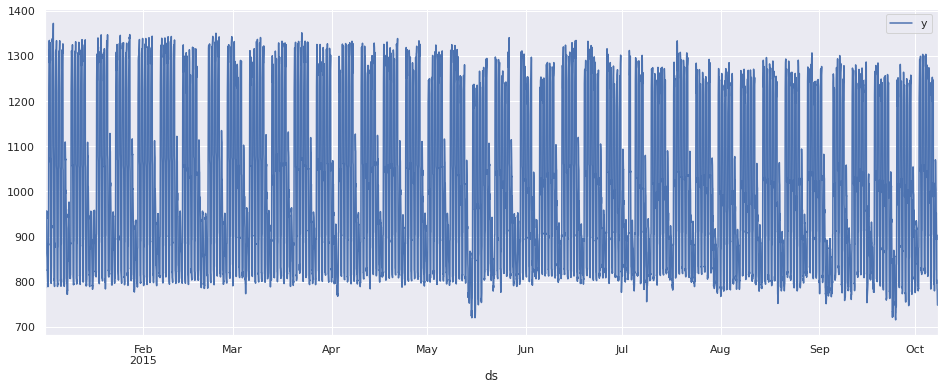

In [12]:
train_df.set_index('ds').plot(figsize=figsize);

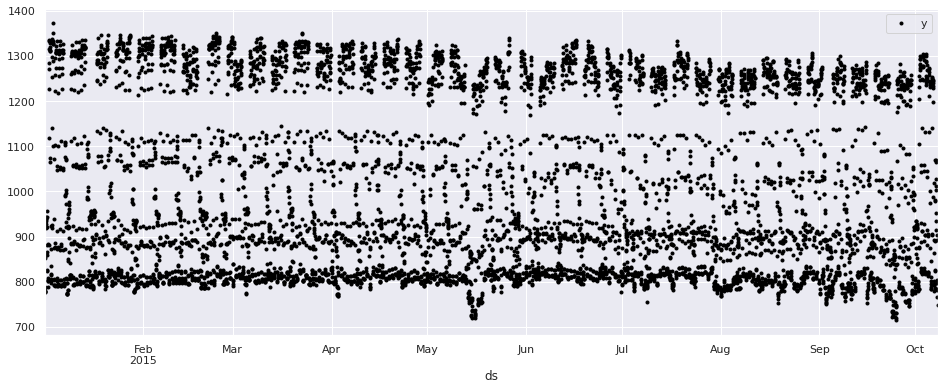

In [13]:
train_df.set_index('ds').plot(marker='.', linestyle='none', colormap='gray', figsize=figsize);

### Train the NP Models (with 5th/95th Quantiles)
- `m1`: NP with default features
- `m2`: NP with parametric time-based features (like in Facebook Prophet)
- `m3`: NP with 1-layer AR
- `m4`: NP with 4-layer deep AR

In [14]:
quantile_lo, quantile_hi = 0.05, 0.95
quantiles = [quantile_lo, quantile_hi]

In [15]:
m1 = NeuralProphet(
    quantiles=quantiles,
)
m2 = NeuralProphet(
    weekly_seasonality=6,
    daily_seasonality=10,
    trend_reg=1,
    learning_rate=0.01,
    quantiles=quantiles,
)
m3 = NeuralProphet(
    growth='off',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=3*24,
    ar_reg=1,
    learning_rate=0.01,
    quantiles=quantiles,
)
m4 = NeuralProphet(
    growth='off',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=3*24,
    num_hidden_layers=4,
    d_hidden=32,
    learning_rate=0.003,
    quantiles=quantiles,
)

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.


Train the 4 models. You can either concatonate the train and val set into one full training set or use the val set separately for hyperparameter tuning. 

In [16]:
%%time
random_seed = 0
set_random_seed(random_seed)
metrics1 = m1.fit(pd.concat([train_df, val_df]), freq='H')
# metrics1 = m1.fit(train_df, freq='H', validation_df=val_df)
set_random_seed(random_seed)
metrics2 = m2.fit(pd.concat([train_df, val_df]), freq='H')
# metrics2 = m2.fit(train_df, freq='H', validation_df=val_df)
set_random_seed(random_seed)
metrics3 = m3.fit(pd.concat([train_df, val_df]), freq='H')
# metrics3 = m3.fit(train_df, freq='H', validation_df=val_df)
set_random_seed(random_seed)
metrics4 = m4.fit(pd.concat([train_df, val_df]), freq='H')
# metrics4 = m4.fit(train_df, freq='H', validation_df=val_df)
# metrics4 = m4.fit(train_df, freq='H', validation_df=val_df, progress='plot')

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 111


  0%|          | 0/146 [00:00<?, ?it/s]

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([292, 1, 1])) that is different to the input size (torch.Size([292, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.92E-02, min: 1.61E-01


  0%|          | 0/146 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 5.92E-02, min: 5.05E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.05E-02
Epoch[111/111]: 100%|██████████| 111/111 [01:08<00:00,  1.62it/s, SmoothL1Loss=0.00934, MAE=64.8, RMSE=80.7, Loss=0.00886, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 111
Epoch[111/111]: 100%|██████████| 111/111 [01:09<00:00,  1.59it/s, SmoothL1Loss=0.00572, MAE=45, RMSE=62, Loss=0

CPU times: user 8min 58s, sys: 685 ms, total: 8min 58s
Wall time: 4min 46s


In [17]:
metrics1.tail(1)

,SmoothL1Loss,MAE,RMSE,Loss,RegLoss
110,0.009335,64.752761,80.731819,0.008858,0.0


In [18]:
metrics2.tail(1)

,SmoothL1Loss,MAE,RMSE,Loss,RegLoss
110,0.00572,44.985246,62.022903,0.013512,0.007895


In [19]:
metrics3.tail(1)

,SmoothL1Loss,MAE,RMSE,Loss,RegLoss
110,0.001844,23.764286,35.099933,0.003229,0.001175


In [20]:
metrics4.tail(1)

,SmoothL1Loss,MAE,RMSE,Loss,RegLoss
110,0.00015,7.040787,10.012148,0.000151,0.0


**Get forecasts of out-of-sample (OOS) test_df**

In [21]:
forecast1 = m1.predict(test_df)
forecast2 = m2.predict(test_df)
forecast3 = m3.predict(test_df)
forecast4 = m4.predict(test_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO

In [22]:
forecast1

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_weekly,season_daily
0,2015-12-09 06:00:00,803.410865,213.470483,1016.881348,945.543091,1107.758789,1060.980103,-35.857937,-8.240889
1,2015-12-09 07:00:00,868.264194,248.532681,1116.796875,1029.379395,1210.215942,1061.019531,-43.928310,99.705711
2,2015-12-09 08:00:00,975.752982,199.357614,1175.110596,1094.900024,1258.766602,1061.058838,-52.160545,166.212280
3,2015-12-09 09:00:00,983.268943,201.886819,1185.155762,1118.851929,1266.527100,1061.098389,-60.508984,184.566437
4,2015-12-09 10:00:00,1095.825986,80.031680,1175.857666,1114.193604,1258.925903,1061.137695,-68.925369,183.645309
...,...,...,...,...,...,...,...,...,...
542,2015-12-31 20:00:00,845.563081,29.672698,875.235779,811.429382,945.432861,1082.336304,-102.217331,-104.883202
543,2015-12-31 21:00:00,827.530521,10.323239,837.853760,765.876587,905.674255,1082.375732,-93.716499,-150.805496
544,2015-12-31 22:00:00,829.256300,-15.792677,813.463623,731.963013,905.580322,1082.415039,-85.029152,-183.922333
545,2015-12-31 23:00:00,813.937205,-9.768138,804.169067,724.962585,902.299255,1082.454468,-76.212311,-202.073105


In [23]:
forecast2

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_weekly,season_daily
0,2015-12-09 06:00:00,803.410865,133.723962,937.134827,901.129517,1008.774536,1067.992065,-125.666420,-5.190844
1,2015-12-09 07:00:00,868.264194,179.030728,1047.294922,1035.315918,1105.245483,1068.036865,-138.488937,117.747009
2,2015-12-09 08:00:00,975.752982,92.273996,1068.026978,1068.026978,1122.293457,1068.081543,-147.623108,147.568481
3,2015-12-09 09:00:00,983.268943,119.330545,1102.599487,1102.599487,1145.322266,1068.126465,-152.871216,187.344330
4,2015-12-09 10:00:00,1095.825986,6.785098,1102.611084,1102.611084,1140.619263,1068.171265,-154.208557,188.648331
...,...,...,...,...,...,...,...,...,...
542,2015-12-31 20:00:00,845.563081,-8.892365,836.670715,836.670715,888.523743,1092.267822,-159.046280,-96.550827
543,2015-12-31 21:00:00,827.530521,-22.763187,804.767334,804.767334,869.326294,1092.312500,-131.355423,-156.189774
544,2015-12-31 22:00:00,829.256300,-23.404798,805.851501,805.851501,850.884277,1092.357422,-102.449158,-184.056686
545,2015-12-31 23:00:00,813.937205,4.846181,818.783386,818.783386,872.742371,1092.402100,-73.249458,-200.369278


In [24]:
forecast3

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,ar1,trend
0,2015-12-09 06:00:00,803.410865,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-12-09 07:00:00,868.264194,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-12-09 08:00:00,975.752982,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-12-09 09:00:00,983.268943,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-12-09 10:00:00,1095.825986,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
542,2015-12-31 20:00:00,845.563081,6.527862,852.090942,811.188354,895.657959,104.948174,747.142761
543,2015-12-31 21:00:00,827.530521,-54.109867,773.420654,732.518311,816.988037,26.277903,747.142761
544,2015-12-31 22:00:00,829.256300,-5.369886,823.886414,782.984314,867.454773,76.743652,747.142761
545,2015-12-31 23:00:00,813.937205,22.968312,836.905518,796.003418,880.474854,89.762749,747.142761


In [25]:
forecast4

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,ar1,trend
0,2015-12-09 06:00:00,803.410865,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-12-09 07:00:00,868.264194,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-12-09 08:00:00,975.752982,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-12-09 09:00:00,983.268943,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-12-09 10:00:00,1095.825986,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
542,2015-12-31 20:00:00,845.563081,3.447478,849.010559,839.433228,857.77417,-101.587242,950.597778
543,2015-12-31 21:00:00,827.530521,-9.749881,817.78064,812.949219,822.213074,-132.817169,950.597778
544,2015-12-31 22:00:00,829.256300,-5.238111,824.018188,810.649231,837.366394,-126.579651,950.597778
545,2015-12-31 23:00:00,813.937205,-1.791819,812.145386,801.797058,822.367554,-138.452423,950.597778


**Plot QR forecasts with OOS test_df**

In [26]:
cutoff = 7*24 # 0
x_size = 12
y_size = 6
figsize = (x_size, y_size)
plotting_backend = 'default'

WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.
WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.


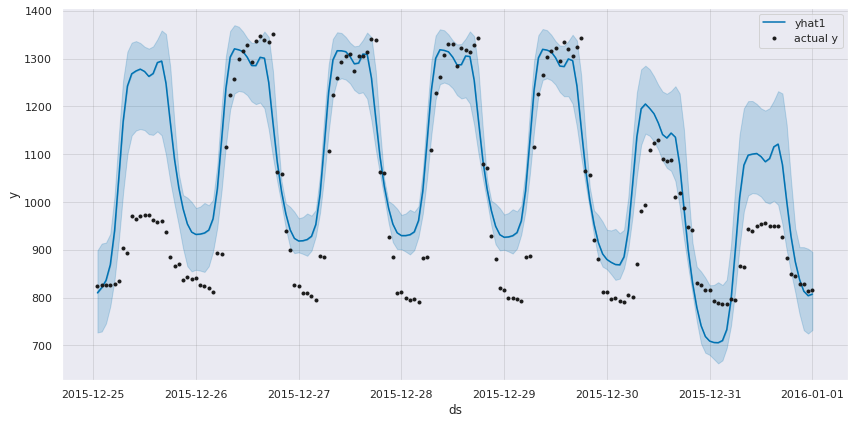

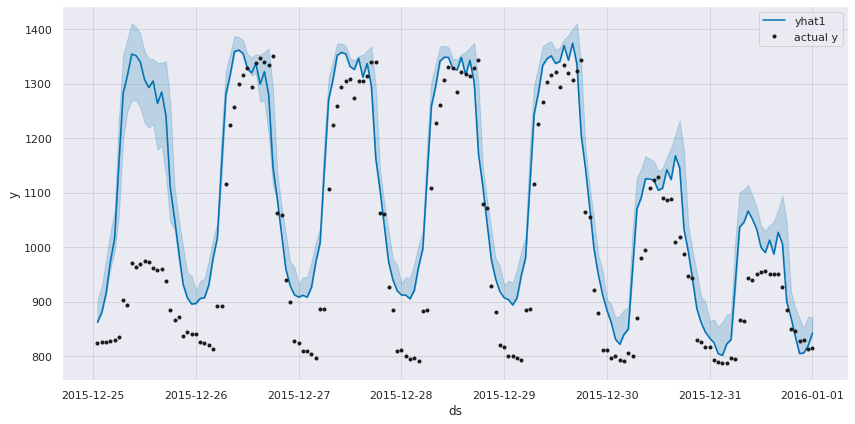

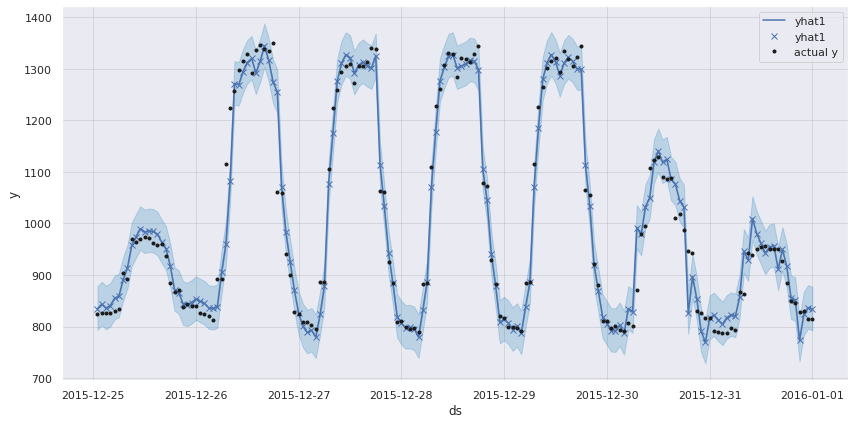

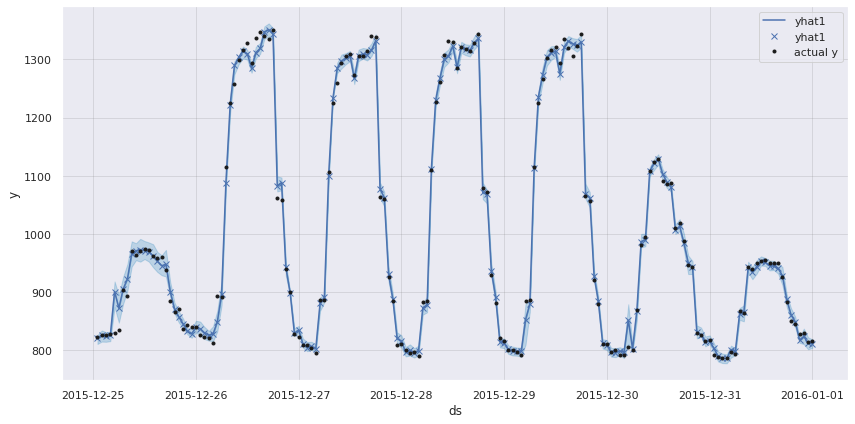

In [27]:
m1 = m1.highlight_nth_step_ahead_of_each_forecast(1)
m2 = m2.highlight_nth_step_ahead_of_each_forecast(1)
m3 = m3.highlight_nth_step_ahead_of_each_forecast(1)
m4 = m4.highlight_nth_step_ahead_of_each_forecast(1)

fig1 = m1.plot(forecast1[-7*24:], figsize=figsize, plotting_backend=plotting_backend)
fig2 = m2.plot(forecast2[-7*24:], figsize=figsize, plotting_backend=plotting_backend)
fig3 = m3.plot(forecast3[-7*24:], figsize=figsize, plotting_backend=plotting_backend)
fig4 = m4.plot(forecast4[-7*24:], figsize=figsize, plotting_backend=plotting_backend)

### Conformalize and plot

In [28]:
alpha = 0.1

**Naive**

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


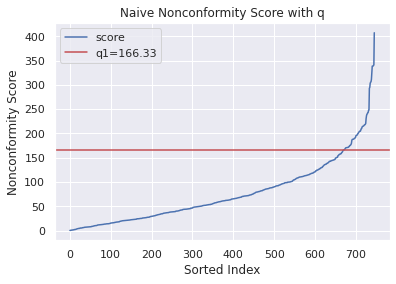

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


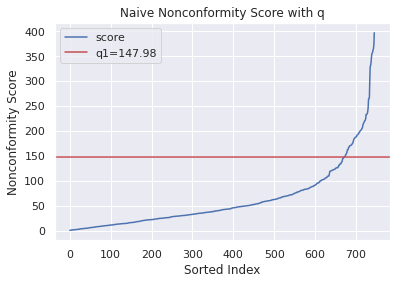

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


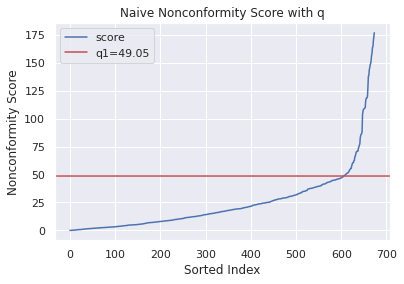

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


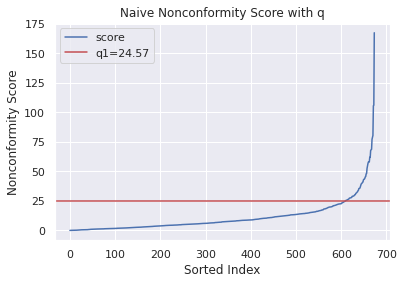

In [29]:
method='naive'
m1.conformalize(cal_df, alpha=alpha, method=method)
m2.conformalize(cal_df, alpha=alpha, method=method)
m3.conformalize(cal_df, alpha=alpha, method=method)
m4.conformalize(cal_df, alpha=alpha, method=method)

In [30]:
naive_qhat1, naive_qhat2, naive_qhat3, naive_qhat4 = m1.q_hats[0], m2.q_hats[0], m3.q_hats[0], m4.q_hats[0]
naive_qhat1, naive_qhat2, naive_qhat3, naive_qhat4

(166.3266485234376, 147.98235627343752, 49.048416660937505, 24.572715671874903)

Get forecasts and *naive* conformal prediction interval of OOS test_df

In [31]:
naive_forecast1 = m1.predict(test_df)
naive_forecast2 = m2.predict(test_df)
naive_forecast3 = m3.predict(test_df)
naive_forecast4 = m4.predict(test_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO

In [32]:
# method='naive'
# naive_forecast1 = m1.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)
# naive_forecast2 = m2.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)
# naive_forecast3 = m3.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)
# naive_forecast4 = m4.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)

In [33]:
naive_forecast1

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_weekly,season_daily,yhat1 - qhat1,yhat1 + qhat1
0,2015-12-09 06:00:00,803.410865,213.470483,1016.881348,945.543091,1107.758789,1060.980103,-35.857937,-8.240889,850.554699,1183.207996
1,2015-12-09 07:00:00,868.264194,248.532681,1116.796875,1029.379395,1210.215942,1061.019531,-43.928310,99.705711,950.470226,1283.123524
2,2015-12-09 08:00:00,975.752982,199.357614,1175.110596,1094.900024,1258.766602,1061.058838,-52.160545,166.212280,1008.783947,1341.437244
3,2015-12-09 09:00:00,983.268943,201.886819,1185.155762,1118.851929,1266.527100,1061.098389,-60.508984,184.566437,1018.829113,1351.482410
4,2015-12-09 10:00:00,1095.825986,80.031680,1175.857666,1114.193604,1258.925903,1061.137695,-68.925369,183.645309,1009.531017,1342.184315
...,...,...,...,...,...,...,...,...,...,...,...
542,2015-12-31 20:00:00,845.563081,29.672698,875.235779,811.429382,945.432861,1082.336304,-102.217331,-104.883202,708.909130,1041.562427
543,2015-12-31 21:00:00,827.530521,10.323239,837.853760,765.876587,905.674255,1082.375732,-93.716499,-150.805496,671.527111,1004.180408
544,2015-12-31 22:00:00,829.256300,-15.792677,813.463623,731.963013,905.580322,1082.415039,-85.029152,-183.922333,647.136975,979.790272
545,2015-12-31 23:00:00,813.937205,-9.768138,804.169067,724.962585,902.299255,1082.454468,-76.212311,-202.073105,637.842419,970.495716


In [34]:
naive_forecast2

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_weekly,season_daily,yhat1 - qhat1,yhat1 + qhat1
0,2015-12-09 06:00:00,803.410865,133.723962,937.134827,901.129517,1008.774536,1067.992065,-125.666420,-5.190844,789.152470,1085.117183
1,2015-12-09 07:00:00,868.264194,179.030728,1047.294922,1035.315918,1105.245483,1068.036865,-138.488937,117.747009,899.312566,1195.277278
2,2015-12-09 08:00:00,975.752982,92.273996,1068.026978,1068.026978,1122.293457,1068.081543,-147.623108,147.568481,920.044621,1216.009334
3,2015-12-09 09:00:00,983.268943,119.330545,1102.599487,1102.599487,1145.322266,1068.126465,-152.871216,187.344330,954.617131,1250.581844
4,2015-12-09 10:00:00,1095.825986,6.785098,1102.611084,1102.611084,1140.619263,1068.171265,-154.208557,188.648331,954.628728,1250.593440
...,...,...,...,...,...,...,...,...,...,...,...
542,2015-12-31 20:00:00,845.563081,-8.892365,836.670715,836.670715,888.523743,1092.267822,-159.046280,-96.550827,688.688359,984.653072
543,2015-12-31 21:00:00,827.530521,-22.763187,804.767334,804.767334,869.326294,1092.312500,-131.355423,-156.189774,656.784978,952.749690
544,2015-12-31 22:00:00,829.256300,-23.404798,805.851501,805.851501,850.884277,1092.357422,-102.449158,-184.056686,657.869145,953.833858
545,2015-12-31 23:00:00,813.937205,4.846181,818.783386,818.783386,872.742371,1092.402100,-73.249458,-200.369278,670.801030,966.765743


In [35]:
naive_forecast3

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,ar1,trend,yhat1 - qhat1,yhat1 + qhat1
0,2015-12-09 06:00:00,803.410865,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-12-09 07:00:00,868.264194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-12-09 08:00:00,975.752982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-12-09 09:00:00,983.268943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-12-09 10:00:00,1095.825986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
542,2015-12-31 20:00:00,845.563081,6.527862,852.090942,811.188354,895.657959,104.948174,747.142761,803.042526,901.139359
543,2015-12-31 21:00:00,827.530521,-54.109867,773.420654,732.518311,816.988037,26.277903,747.142761,724.372238,822.469071
544,2015-12-31 22:00:00,829.256300,-5.369886,823.886414,782.984314,867.454773,76.743652,747.142761,774.837997,872.93483
545,2015-12-31 23:00:00,813.937205,22.968312,836.905518,796.003418,880.474854,89.762749,747.142761,787.857101,885.953934


In [36]:
naive_forecast4

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,ar1,trend,yhat1 - qhat1,yhat1 + qhat1
0,2015-12-09 06:00:00,803.410865,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-12-09 07:00:00,868.264194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-12-09 08:00:00,975.752982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-12-09 09:00:00,983.268943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-12-09 10:00:00,1095.825986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
542,2015-12-31 20:00:00,845.563081,3.447478,849.010559,839.433228,857.77417,-101.587242,950.597778,824.437843,873.583275
543,2015-12-31 21:00:00,827.530521,-9.749881,817.78064,812.949219,822.213074,-132.817169,950.597778,793.207924,842.353355
544,2015-12-31 22:00:00,829.256300,-5.238111,824.018188,810.649231,837.366394,-126.579651,950.597778,799.445473,848.590904
545,2015-12-31 23:00:00,813.937205,-1.791819,812.145386,801.797058,822.367554,-138.452423,950.597778,787.57267,836.718101


Plot QR forecasts and *naive* conformal prediction intervals with OOS test_df

WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.
WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.


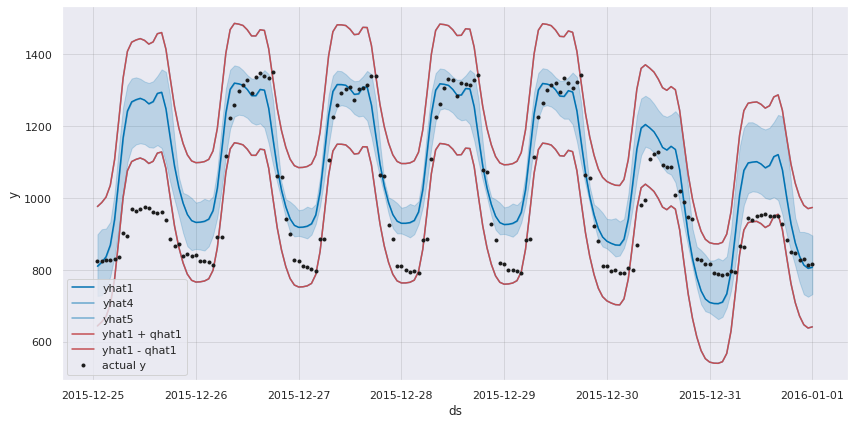

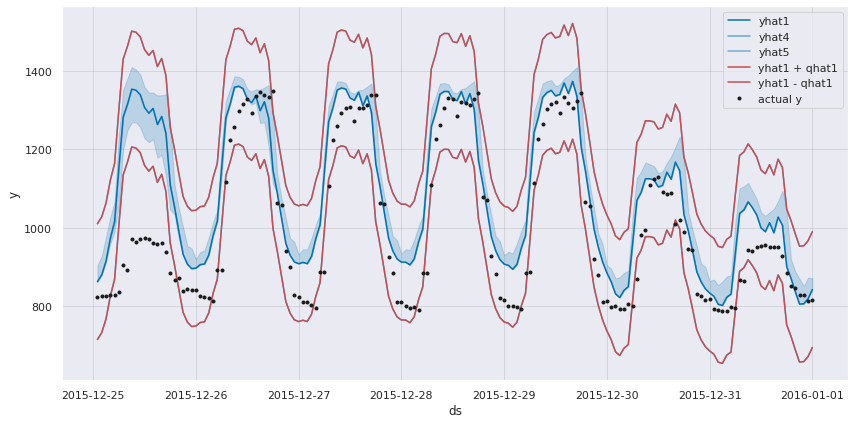

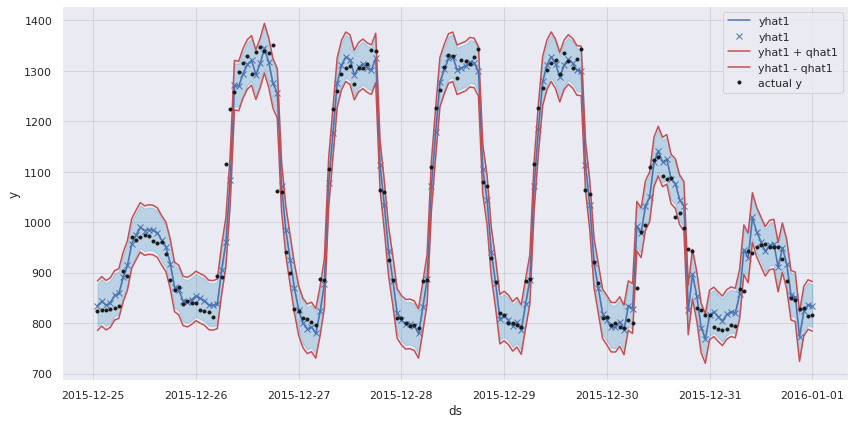

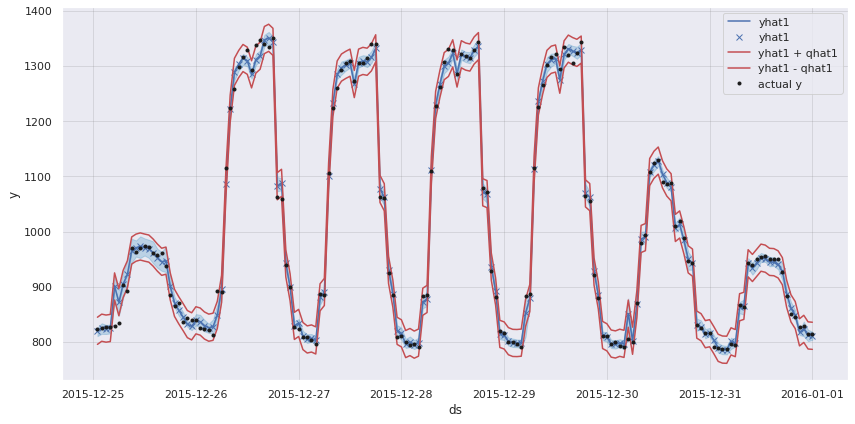

In [37]:
m1 = m1.highlight_nth_step_ahead_of_each_forecast(1)
m2 = m2.highlight_nth_step_ahead_of_each_forecast(1)
m3 = m3.highlight_nth_step_ahead_of_each_forecast(1)
m4 = m4.highlight_nth_step_ahead_of_each_forecast(1)

fig1 = m1.plot(naive_forecast1[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)
fig2 = m2.plot(naive_forecast2[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)
fig3 = m3.plot(naive_forecast3[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)
fig4 = m4.plot(naive_forecast4[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)

**CQR**

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


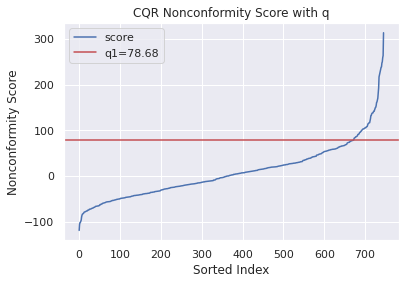

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


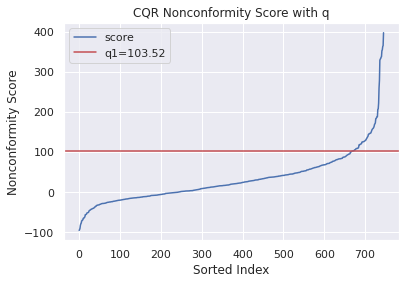

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


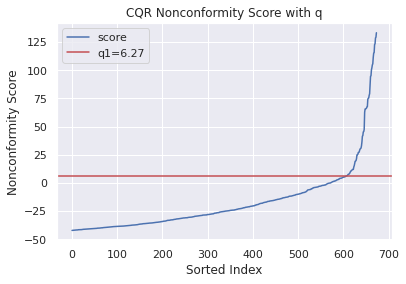

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


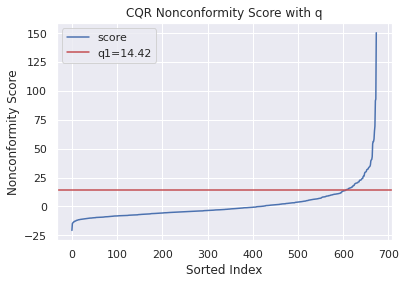

In [38]:
method='cqr'
m1.conformalize(cal_df, alpha=alpha, method=method)
m2.conformalize(cal_df, alpha=alpha, method=method)
m3.conformalize(cal_df, alpha=alpha, method=method)
m4.conformalize(cal_df, alpha=alpha, method=method)

In [39]:
cqr_qhat1, cqr_qhat2, cqr_qhat3, cqr_qhat4 = m1.q_hats[0], m2.q_hats[0], m3.q_hats[0], m4.q_hats[0]
cqr_qhat1, cqr_qhat2, cqr_qhat3, cqr_qhat4

(78.68084134843753, 103.51721027421877, 6.270407437499898, 14.423869778906237)

Get forecasts and *CQR* conformal prediction interval of OOS test_df

In [40]:
cqr_forecast1 = m1.predict(test_df)
cqr_forecast2 = m2.predict(test_df)
cqr_forecast3 = m3.predict(test_df)
cqr_forecast4 = m4.predict(test_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO

In [41]:
# method='cqr'
# cqr_adv_forecast1 = m1.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)
# cqr_forecast2 = m2.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)
# cqr_forecast3 = m3.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)
# cqr_forecast4 = m4.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)

In [42]:
cqr_forecast1

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_weekly,season_daily,yhat1 95.0% - qhat1,yhat1 95.0% + qhat1,yhat1 5.0% - qhat1,yhat1 5.0% + qhat1
0,2015-12-09 06:00:00,803.410865,213.470483,1016.881348,945.543091,1107.758789,1060.980103,-35.857937,-8.240889,1029.077948,1186.439630,866.862249,1024.223932
1,2015-12-09 07:00:00,868.264194,248.532681,1116.796875,1029.379395,1210.215942,1061.019531,-43.928310,99.705711,1131.535101,1288.896784,950.698553,1108.060236
2,2015-12-09 08:00:00,975.752982,199.357614,1175.110596,1094.900024,1258.766602,1061.058838,-52.160545,166.212280,1180.085760,1337.447443,1016.219183,1173.580866
3,2015-12-09 09:00:00,983.268943,201.886819,1185.155762,1118.851929,1266.527100,1061.098389,-60.508984,184.566437,1187.846258,1345.207941,1040.171087,1197.532770
4,2015-12-09 10:00:00,1095.825986,80.031680,1175.857666,1114.193604,1258.925903,1061.137695,-68.925369,183.645309,1180.245062,1337.606745,1035.512762,1192.874445
...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,2015-12-31 20:00:00,845.563081,29.672698,875.235779,811.429382,945.432861,1082.336304,-102.217331,-104.883202,866.752020,1024.113703,732.748541,890.110224
543,2015-12-31 21:00:00,827.530521,10.323239,837.853760,765.876587,905.674255,1082.375732,-93.716499,-150.805496,826.993414,984.355097,687.195746,844.557428
544,2015-12-31 22:00:00,829.256300,-15.792677,813.463623,731.963013,905.580322,1082.415039,-85.029152,-183.922333,826.899481,984.261164,653.282171,810.643854
545,2015-12-31 23:00:00,813.937205,-9.768138,804.169067,724.962585,902.299255,1082.454468,-76.212311,-202.073105,823.618414,980.980097,646.281744,803.643427


In [43]:
cqr_forecast2

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_weekly,season_daily,yhat1 95.0% - qhat1,yhat1 95.0% + qhat1,yhat1 5.0% - qhat1,yhat1 5.0% + qhat1
0,2015-12-09 06:00:00,803.410865,133.723962,937.134827,901.129517,1008.774536,1067.992065,-125.666420,-5.190844,905.257326,1112.291746,797.612306,1004.646727
1,2015-12-09 07:00:00,868.264194,179.030728,1047.294922,1035.315918,1105.245483,1068.036865,-138.488937,117.747009,1001.728273,1208.762694,931.798708,1138.833128
2,2015-12-09 08:00:00,975.752982,92.273996,1068.026978,1068.026978,1122.293457,1068.081543,-147.623108,147.568481,1018.776247,1225.810667,964.509767,1171.544188
3,2015-12-09 09:00:00,983.268943,119.330545,1102.599487,1102.599487,1145.322266,1068.126465,-152.871216,187.344330,1041.805055,1248.839476,999.082277,1206.116698
4,2015-12-09 10:00:00,1095.825986,6.785098,1102.611084,1102.611084,1140.619263,1068.171265,-154.208557,188.648331,1037.102052,1244.136473,999.093874,1206.128294
...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,2015-12-31 20:00:00,845.563081,-8.892365,836.670715,836.670715,888.523743,1092.267822,-159.046280,-96.550827,785.006532,992.040953,733.153505,940.187926
543,2015-12-31 21:00:00,827.530521,-22.763187,804.767334,804.767334,869.326294,1092.312500,-131.355423,-156.189774,765.809084,972.843504,701.250124,908.284544
544,2015-12-31 22:00:00,829.256300,-23.404798,805.851501,805.851501,850.884277,1092.357422,-102.449158,-184.056686,747.367067,954.401488,702.334291,909.368712
545,2015-12-31 23:00:00,813.937205,4.846181,818.783386,818.783386,872.742371,1092.402100,-73.249458,-200.369278,769.225160,976.259581,715.266176,922.300597


In [44]:
cqr_forecast3

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,ar1,trend,yhat1 95.0% - qhat1,yhat1 95.0% + qhat1,yhat1 5.0% - qhat1,yhat1 5.0% + qhat1
0,2015-12-09 06:00:00,803.410865,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-12-09 07:00:00,868.264194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-12-09 08:00:00,975.752982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-12-09 09:00:00,983.268943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-12-09 10:00:00,1095.825986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
542,2015-12-31 20:00:00,845.563081,6.527862,852.090942,811.188354,895.657959,104.948174,747.142761,889.387552,901.928366,804.917947,817.458762
543,2015-12-31 21:00:00,827.530521,-54.109867,773.420654,732.518311,816.988037,26.277903,747.142761,810.71763,823.258445,726.247903,738.788718
544,2015-12-31 22:00:00,829.256300,-5.369886,823.886414,782.984314,867.454773,76.743652,747.142761,861.184366,873.72518,776.713907,789.254721
545,2015-12-31 23:00:00,813.937205,22.968312,836.905518,796.003418,880.474854,89.762749,747.142761,874.204446,886.745261,789.733011,802.273825


In [45]:
cqr_forecast4

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,ar1,trend,yhat1 95.0% - qhat1,yhat1 95.0% + qhat1,yhat1 5.0% - qhat1,yhat1 5.0% + qhat1
0,2015-12-09 06:00:00,803.410865,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-12-09 07:00:00,868.264194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-12-09 08:00:00,975.752982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-12-09 09:00:00,983.268943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-12-09 10:00:00,1095.825986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
542,2015-12-31 20:00:00,845.563081,3.447478,849.010559,839.433228,857.77417,-101.587242,950.597778,843.3503,872.19804,825.009358,853.857097
543,2015-12-31 21:00:00,827.530521,-9.749881,817.78064,812.949219,822.213074,-132.817169,950.597778,807.789204,836.636944,798.525349,827.373089
544,2015-12-31 22:00:00,829.256300,-5.238111,824.018188,810.649231,837.366394,-126.579651,950.597778,822.942524,851.790264,796.225361,825.073101
545,2015-12-31 23:00:00,813.937205,-1.791819,812.145386,801.797058,822.367554,-138.452423,950.597778,807.943684,836.791423,787.373188,816.220928


Plot QR forecasts and *CQR* conformal prediction interval with OOS test_df

WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.
WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.


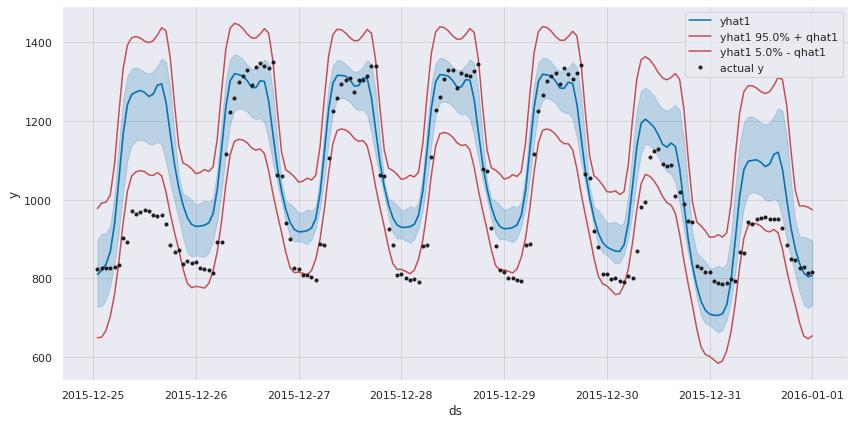

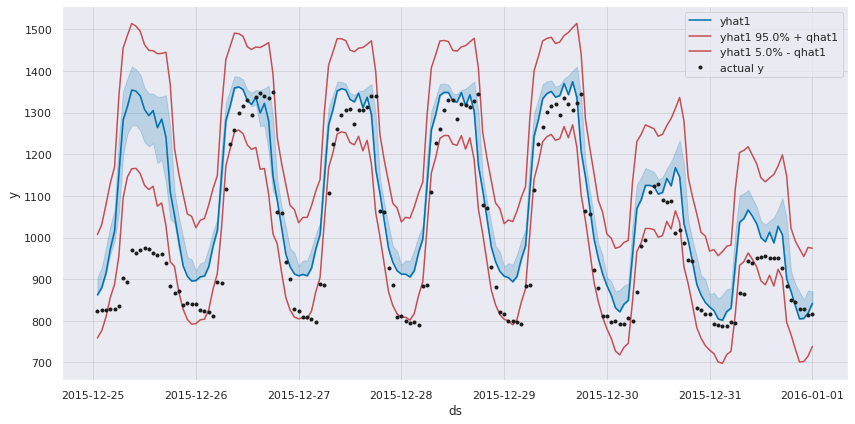

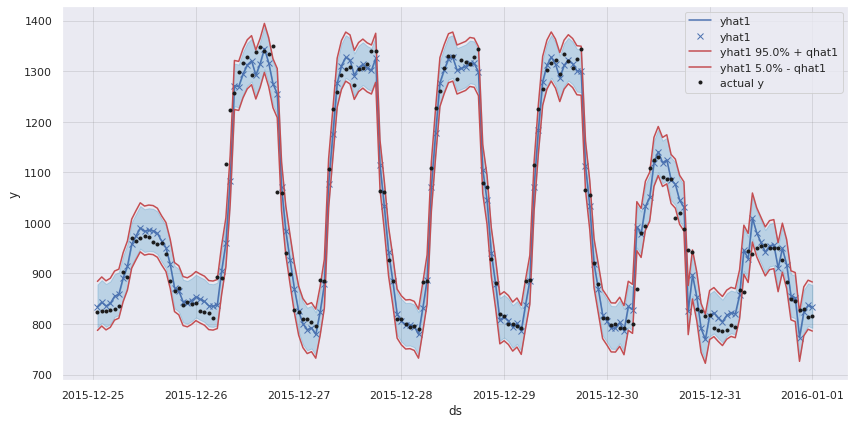

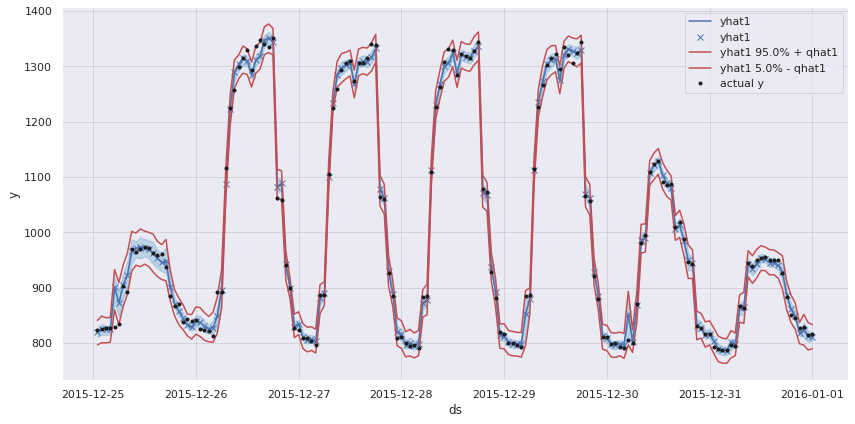

In [46]:
m1 = m1.highlight_nth_step_ahead_of_each_forecast(1)
m2 = m2.highlight_nth_step_ahead_of_each_forecast(1)
m3 = m3.highlight_nth_step_ahead_of_each_forecast(1)
m4 = m4.highlight_nth_step_ahead_of_each_forecast(1)

fig1 = m1.plot(cqr_forecast1[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)
fig2 = m2.plot(cqr_forecast2[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)
fig3 = m3.plot(cqr_forecast3[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)
fig4 = m4.plot(cqr_forecast4[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)

**CQR Advanced**

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


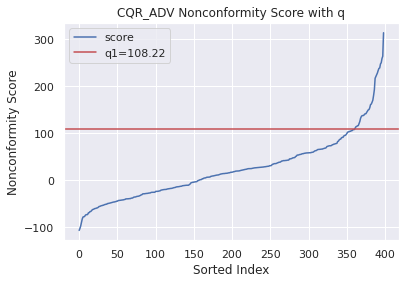

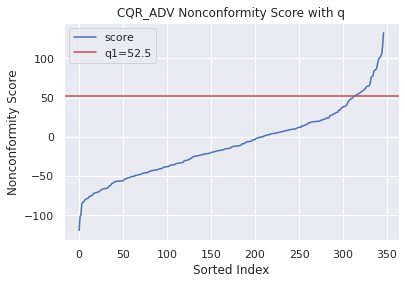

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


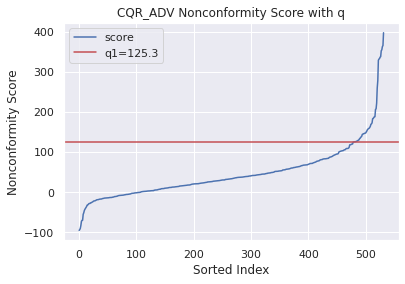

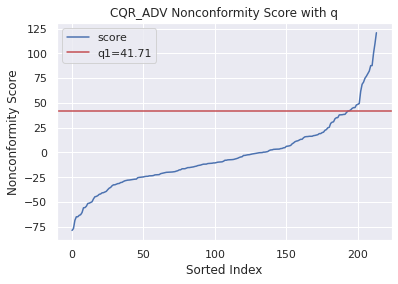

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


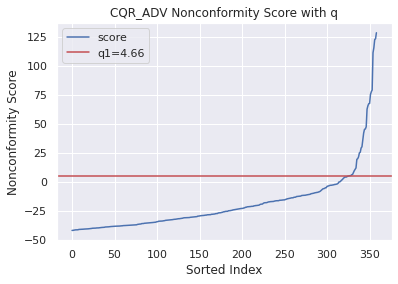

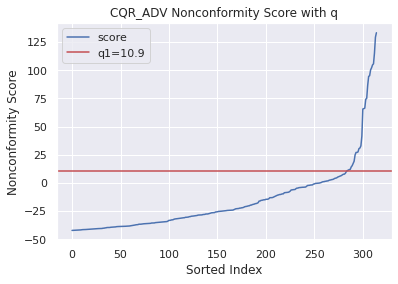

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


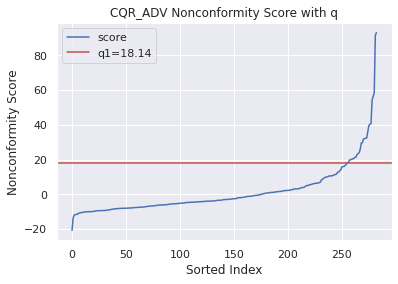

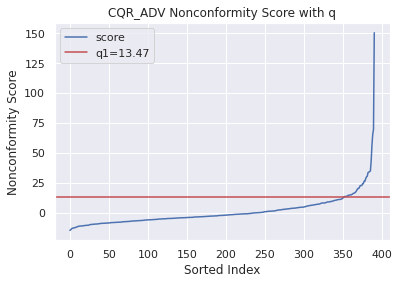

In [47]:
method='cqr_adv'
m1.conformalize(cal_df, alpha=alpha, method=method)
m2.conformalize(cal_df, alpha=alpha, method=method)
m3.conformalize(cal_df, alpha=alpha, method=method)
m4.conformalize(cal_df, alpha=alpha, method=method)

In [48]:
cqr_lo_qhat1, cqr_lo_qhat2, cqr_lo_qhat3, cqr_lo_qhat4 = m1.q_hats[0], m2.q_hats[0], m3.q_hats[0], m4.q_hats[0]
cqr_hi_qhat1, cqr_hi_qhat2, cqr_hi_qhat3, cqr_hi_qhat4 = m1.q_hats[1], m2.q_hats[1], m3.q_hats[1], m4.q_hats[1]

cqr_lo_qhat1, cqr_hi_qhat1, cqr_lo_qhat2, cqr_hi_qhat2, cqr_lo_qhat3, cqr_hi_qhat3, cqr_lo_qhat4, cqr_hi_qhat4

(108.21679663437499,
 52.4950945703124,
 125.2962213414063,
 41.711907132812485,
 4.657375940625002,
 10.896213682031203,
 18.13939143750008,
 13.467183281250072)

In [49]:
# Compare again with CQR
cqr_qhat1, cqr_qhat2, cqr_qhat3, cqr_qhat4

(78.68084134843753, 103.51721027421877, 6.270407437499898, 14.423869778906237)

Get forecasts and *CQR Advanced* conformal prediction interval of OOS test_df

In [50]:
cqr_adv_forecast1 = m1.predict(test_df)
cqr_adv_forecast2 = m2.predict(test_df)
cqr_adv_forecast3 = m3.predict(test_df)
cqr_adv_forecast4 = m4.predict(test_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.817% of the data.
INFO

In [51]:
cqr_adv_forecast1

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_weekly,season_daily,yhat1 95.0% - qhat1,yhat1 95.0% + qhat1,yhat1 5.0% - qhat1,yhat1 5.0% + qhat1
0,2015-12-09 06:00:00,803.410865,213.470483,1016.881348,945.543091,1107.758789,1060.980103,-35.857937,-8.240889,1055.263694,1160.253884,837.326294,1053.759887
1,2015-12-09 07:00:00,868.264194,248.532681,1116.796875,1029.379395,1210.215942,1061.019531,-43.928310,99.705711,1157.720848,1262.711037,921.162598,1137.596191
2,2015-12-09 08:00:00,975.752982,199.357614,1175.110596,1094.900024,1258.766602,1061.058838,-52.160545,166.212280,1206.271507,1311.261696,986.683228,1203.116821
3,2015-12-09 09:00:00,983.268943,201.886819,1185.155762,1118.851929,1266.527100,1061.098389,-60.508984,184.566437,1214.032005,1319.022194,1010.635132,1227.068725
4,2015-12-09 10:00:00,1095.825986,80.031680,1175.857666,1114.193604,1258.925903,1061.137695,-68.925369,183.645309,1206.430809,1311.420998,1005.976807,1222.410400
...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,2015-12-31 20:00:00,845.563081,29.672698,875.235779,811.429382,945.432861,1082.336304,-102.217331,-104.883202,892.937767,997.927956,703.212586,919.646179
543,2015-12-31 21:00:00,827.530521,10.323239,837.853760,765.876587,905.674255,1082.375732,-93.716499,-150.805496,853.179161,958.169350,657.659790,874.093384
544,2015-12-31 22:00:00,829.256300,-15.792677,813.463623,731.963013,905.580322,1082.415039,-85.029152,-183.922333,853.085228,958.075417,623.746216,840.179809
545,2015-12-31 23:00:00,813.937205,-9.768138,804.169067,724.962585,902.299255,1082.454468,-76.212311,-202.073105,849.804161,954.794350,616.745789,833.179382


In [52]:
cqr_adv_forecast2

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_weekly,season_daily,yhat1 95.0% - qhat1,yhat1 95.0% + qhat1,yhat1 5.0% - qhat1,yhat1 5.0% + qhat1
0,2015-12-09 06:00:00,803.410865,133.723962,937.134827,901.129517,1008.774536,1067.992065,-125.666420,-5.190844,967.062629,1050.486443,775.833295,1026.425738
1,2015-12-09 07:00:00,868.264194,179.030728,1047.294922,1035.315918,1105.245483,1068.036865,-138.488937,117.747009,1063.533576,1146.957391,910.019697,1160.612139
2,2015-12-09 08:00:00,975.752982,92.273996,1068.026978,1068.026978,1122.293457,1068.081543,-147.623108,147.568481,1080.581550,1164.005364,942.730756,1193.323199
3,2015-12-09 09:00:00,983.268943,119.330545,1102.599487,1102.599487,1145.322266,1068.126465,-152.871216,187.344330,1103.610358,1187.034173,977.303266,1227.895709
4,2015-12-09 10:00:00,1095.825986,6.785098,1102.611084,1102.611084,1140.619263,1068.171265,-154.208557,188.648331,1098.907356,1182.331170,977.314863,1227.907305
...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,2015-12-31 20:00:00,845.563081,-8.892365,836.670715,836.670715,888.523743,1092.267822,-159.046280,-96.550827,846.811836,930.235650,711.374494,961.966937
543,2015-12-31 21:00:00,827.530521,-22.763187,804.767334,804.767334,869.326294,1092.312500,-131.355423,-156.189774,827.614387,911.038201,679.471113,930.063555
544,2015-12-31 22:00:00,829.256300,-23.404798,805.851501,805.851501,850.884277,1092.357422,-102.449158,-184.056686,809.172370,892.596184,680.555280,931.147723
545,2015-12-31 23:00:00,813.937205,4.846181,818.783386,818.783386,872.742371,1092.402100,-73.249458,-200.369278,831.030463,914.454278,693.487165,944.079608


In [53]:
cqr_adv_forecast3

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,ar1,trend,yhat1 95.0% - qhat1,yhat1 95.0% + qhat1,yhat1 5.0% - qhat1,yhat1 5.0% + qhat1
0,2015-12-09 06:00:00,803.410865,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-12-09 07:00:00,868.264194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-12-09 08:00:00,975.752982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-12-09 09:00:00,983.268943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-12-09 10:00:00,1095.825986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
542,2015-12-31 20:00:00,845.563081,6.527862,852.090942,811.188354,895.657959,104.948174,747.142761,884.761745,906.554173,806.530979,815.84573
543,2015-12-31 21:00:00,827.530521,-54.109867,773.420654,732.518311,816.988037,26.277903,747.142761,806.091823,827.884251,727.860935,737.175686
544,2015-12-31 22:00:00,829.256300,-5.369886,823.886414,782.984314,867.454773,76.743652,747.142761,856.558559,878.350987,778.326938,787.64169
545,2015-12-31 23:00:00,813.937205,22.968312,836.905518,796.003418,880.474854,89.762749,747.142761,869.57864,891.371067,791.346042,800.660794


In [54]:
cqr_adv_forecast4

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,ar1,trend,yhat1 95.0% - qhat1,yhat1 95.0% + qhat1,yhat1 5.0% - qhat1,yhat1 5.0% + qhat1
0,2015-12-09 06:00:00,803.410865,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-12-09 07:00:00,868.264194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-12-09 08:00:00,975.752982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-12-09 09:00:00,983.268943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-12-09 10:00:00,1095.825986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
542,2015-12-31 20:00:00,845.563081,3.447478,849.010559,839.433228,857.77417,-101.587242,950.597778,844.306987,871.241353,821.293836,857.572619
543,2015-12-31 21:00:00,827.530521,-9.749881,817.78064,812.949219,822.213074,-132.817169,950.597778,808.74589,835.680257,794.809827,831.08861
544,2015-12-31 22:00:00,829.256300,-5.238111,824.018188,810.649231,837.366394,-126.579651,950.597778,823.899211,850.833577,792.50984,828.788622
545,2015-12-31 23:00:00,813.937205,-1.791819,812.145386,801.797058,822.367554,-138.452423,950.597778,808.90037,835.834737,783.657667,819.93645


Plot QR forecasts and *CQR Advanced* conformal prediction interval with OOS test_df

WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.
WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.


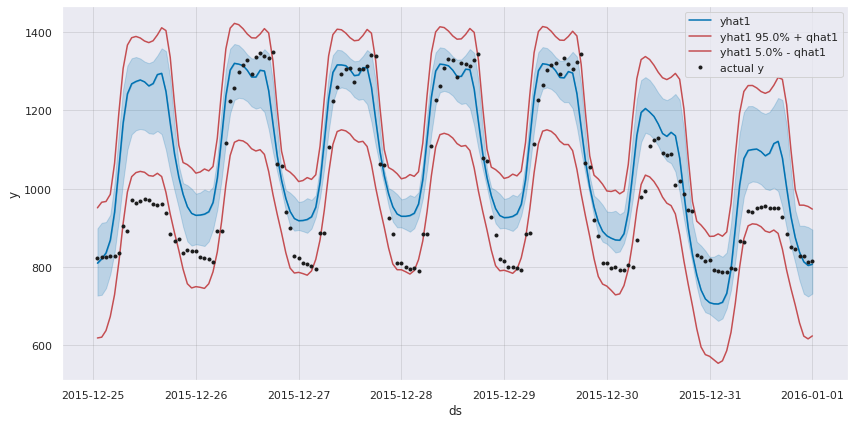

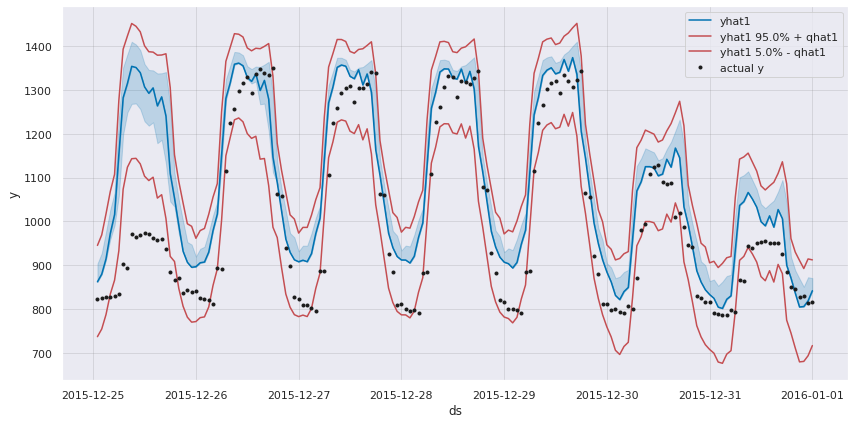

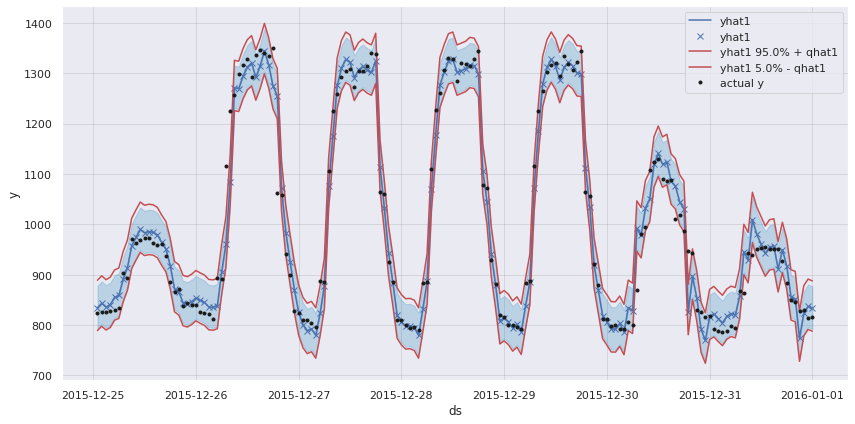

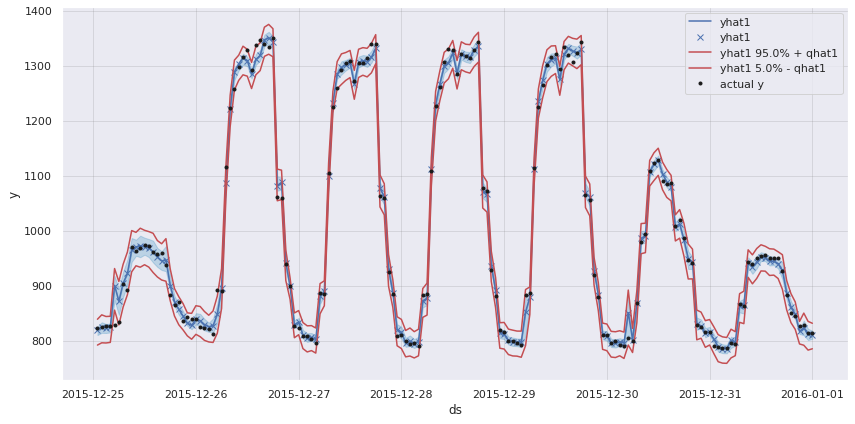

In [55]:
m1 = m1.highlight_nth_step_ahead_of_each_forecast(1)
m2 = m2.highlight_nth_step_ahead_of_each_forecast(1)
m3 = m3.highlight_nth_step_ahead_of_each_forecast(1)
m4 = m4.highlight_nth_step_ahead_of_each_forecast(1)

fig1 = m1.plot(cqr_adv_forecast1[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)
fig2 = m2.plot(cqr_adv_forecast2[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)
fig3 = m3.plot(cqr_adv_forecast3[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)
fig4 = m4.plot(cqr_adv_forecast4[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)

### Evaluate Performance

- **interval_width**: The average prediction interval, or q_hat multiplied by 2 because it is static or non-adaptive. Also the *efficiency* metric.
- **miscoverage_rate**: The actual miscoverage error rate on the OOS test set. Also the *validity* metric.

For the both metrics, the lower the number, the better the performance.



In [56]:
conformal_methods = ['naive', 'cqr', 'cqr_adv']
eval_df = pd.DataFrame(columns=pd.MultiIndex.from_product([conformal_methods, ['interval_width','miscoverage_rate']]))
eval_df = eval_df.reset_index().rename(columns={'index': 'model'})

Enter in the model names

In [57]:
eval_df['model'] = ['m1', 'm2', 'm3', 'm4']

Enter in the **interval_width** (*efficiency* metric)

In [58]:
eval_df['naive', 'interval_width'] = [naive_qhat1*2, naive_qhat2*2, naive_qhat3*2, naive_qhat4*2]

qr_lo_mean1 = cqr_forecast1['yhat1'].mean() - cqr_forecast1['yhat1 5.0%'].mean()
qr_hi_mean1 = cqr_forecast1['yhat1 95.0%'].mean() - cqr_forecast1['yhat1'].mean()
qr_lo_mean2 = cqr_forecast2['yhat1'].mean() - cqr_forecast2['yhat1 5.0%'].mean()
qr_hi_mean2 = cqr_forecast2['yhat1 95.0%'].mean() - cqr_forecast2['yhat1'].mean()
qr_lo_mean3 = cqr_forecast3['yhat1'].mean() - cqr_forecast3['yhat1 5.0%'].mean()
qr_hi_mean3 = cqr_forecast3['yhat1 95.0%'].mean() - cqr_forecast3['yhat1'].mean()
qr_lo_mean4 = cqr_forecast4['yhat1'].mean() - cqr_forecast4['yhat1 5.0%'].mean()
qr_hi_mean4 = cqr_forecast4['yhat1 95.0%'].mean() - cqr_forecast4['yhat1'].mean()
eval_df['cqr', 'interval_width'] = [qr_lo_mean1 + qr_hi_mean1 + cqr_qhat1*2, \
                                    qr_lo_mean2 + qr_hi_mean2 + cqr_qhat2*2, \
                                    qr_lo_mean3 + qr_hi_mean3 + cqr_qhat3*2, \
                                    qr_lo_mean4 + qr_hi_mean4 + cqr_qhat4*2
                                    ]

qr_lo_mean1 = cqr_adv_forecast1['yhat1'].mean() - cqr_adv_forecast1['yhat1 5.0%'].mean()
qr_hi_mean1 = cqr_adv_forecast1['yhat1 95.0%'].mean() - cqr_adv_forecast1['yhat1'].mean()
qr_lo_mean2 = cqr_adv_forecast2['yhat1'].mean() - cqr_adv_forecast2['yhat1 5.0%'].mean()
qr_hi_mean2 = cqr_adv_forecast2['yhat1 95.0%'].mean() - cqr_adv_forecast2['yhat1'].mean()
qr_lo_mean3 = cqr_adv_forecast3['yhat1'].mean() - cqr_adv_forecast3['yhat1 5.0%'].mean()
qr_hi_mean3 = cqr_adv_forecast3['yhat1 95.0%'].mean() - cqr_adv_forecast3['yhat1'].mean()
qr_lo_mean4 = cqr_adv_forecast4['yhat1'].mean() - cqr_adv_forecast4['yhat1 5.0%'].mean()
qr_hi_mean4 = cqr_adv_forecast4['yhat1 95.0%'].mean() - cqr_adv_forecast4['yhat1'].mean()
eval_df['cqr_adv', 'interval_width'] = [qr_lo_mean1 + qr_hi_mean1 + cqr_lo_qhat1 + cqr_hi_qhat1, \
                                        qr_lo_mean2 + qr_hi_mean2 + cqr_lo_qhat2 + cqr_hi_qhat2, \
                                        qr_lo_mean3 + qr_hi_mean3 + cqr_lo_qhat3 + cqr_hi_qhat3, \
                                        qr_lo_mean4 + qr_hi_mean4 + cqr_lo_qhat4 + cqr_hi_qhat4
                                        ]

Enter in the **miscoverage rate** (*validity* metric)

In [59]:
naive_forecast1['check'] = naive_forecast1.apply(lambda row: bool(row['yhat1 - qhat1'] <= row['y'] <= row['yhat1 + qhat1']), axis=1)
naive_forecast2['check'] = naive_forecast2.apply(lambda row: bool(row['yhat1 - qhat1'] <= row['y'] <= row['yhat1 + qhat1']), axis=1)
naive_forecast3['check'] = naive_forecast3.apply(lambda row: bool(row['yhat1 - qhat1'] <= row['y'] <= row['yhat1 + qhat1']), axis=1)
naive_forecast4['check'] = naive_forecast4.apply(lambda row: bool(row['yhat1 - qhat1'] <= row['y'] <= row['yhat1 + qhat1']), axis=1)
naive_coverage1 = naive_forecast1['check'].sum() / len(naive_forecast1)
naive_coverage2 = naive_forecast2['check'].sum() / len(naive_forecast2)
naive_coverage3 = naive_forecast3['check'].sum() / len(naive_forecast3)
naive_coverage4 = naive_forecast4['check'].sum() / len(naive_forecast4)
eval_df['naive', 'miscoverage_rate'] = [1-naive_coverage1, 1-naive_coverage2, 1-naive_coverage3, 1-naive_coverage4]  # 1 - coverage for the miscoverage

In [60]:
quantile_lo_str = str(quantile_lo*100)
quantile_hi_str = str(quantile_hi*100)
cqr_forecast1['check'] = cqr_forecast1.apply(lambda row: bool(row[f'yhat1 {quantile_lo_str}% - qhat1'] <= row['y'] <= row[f'yhat1 {quantile_hi_str}% + qhat1']), axis=1)
cqr_forecast2['check'] = cqr_forecast2.apply(lambda row: bool(row[f'yhat1 {quantile_lo_str}% - qhat1'] <= row['y'] <= row[f'yhat1 {quantile_hi_str}% + qhat1']), axis=1)
cqr_forecast3['check'] = cqr_forecast3.apply(lambda row: bool(row[f'yhat1 {quantile_lo_str}% - qhat1'] <= row['y'] <= row[f'yhat1 {quantile_hi_str}% + qhat1']), axis=1)
cqr_forecast4['check'] = cqr_forecast4.apply(lambda row: bool(row[f'yhat1 {quantile_lo_str}% - qhat1'] <= row['y'] <= row[f'yhat1 {quantile_hi_str}% + qhat1']), axis=1)
cqr_coverage1 = cqr_forecast1['check'].sum() / len(cqr_forecast1)
cqr_coverage2 = cqr_forecast2['check'].sum() / len(cqr_forecast2)
cqr_coverage3 = cqr_forecast3['check'].sum() / len(cqr_forecast3)
cqr_coverage4 = cqr_forecast4['check'].sum() / len(cqr_forecast3)
eval_df['cqr', 'miscoverage_rate'] = [1-cqr_coverage1, 1-cqr_coverage2, 1-cqr_coverage3, 1-cqr_coverage4]  # 1 - coverage for the miscoverage


In [61]:
cqr_adv_forecast1['check'] = cqr_adv_forecast1.apply(lambda row: bool(row[f'yhat1 {quantile_lo_str}% - qhat1'] <= row['y'] <= row[f'yhat1 {quantile_hi_str}% + qhat1']), axis=1)
cqr_adv_forecast2['check'] = cqr_adv_forecast2.apply(lambda row: bool(row[f'yhat1 {quantile_lo_str}% - qhat1'] <= row['y'] <= row[f'yhat1 {quantile_hi_str}% + qhat1']), axis=1)
cqr_adv_forecast3['check'] = cqr_adv_forecast3.apply(lambda row: bool(row[f'yhat1 {quantile_lo_str}% - qhat1'] <= row['y'] <= row[f'yhat1 {quantile_hi_str}% + qhat1']), axis=1)
cqr_adv_forecast4['check'] = cqr_adv_forecast4.apply(lambda row: bool(row[f'yhat1 {quantile_lo_str}% - qhat1'] <= row['y'] <= row[f'yhat1 {quantile_hi_str}% + qhat1']), axis=1)
cqr_adv_coverage1 = cqr_adv_forecast1['check'].sum() / len(cqr_adv_forecast1)
cqr_adv_coverage2 = cqr_adv_forecast2['check'].sum() / len(cqr_adv_forecast2)
cqr_adv_coverage3 = cqr_adv_forecast3['check'].sum() / len(cqr_adv_forecast3)
cqr_adv_coverage4 = cqr_adv_forecast4['check'].sum() / len(cqr_adv_forecast4)
eval_df['cqr_adv', 'miscoverage_rate'] = [1-cqr_adv_coverage1, 1-cqr_adv_coverage2, 1-cqr_adv_coverage3, 1-cqr_adv_coverage4]  # 1 - coverage for the miscoverage

Show evaluation dataframe

In [62]:
eval_df

model          naive                             cqr                   \
        interval_width miscoverage_rate interval_width miscoverage_rate   
0    m1     332.653297         0.113346     298.372167         0.175503   
1    m2     295.964713         0.129799     266.078730         0.186472   
2    m3      98.096833         0.210238      97.011458         0.212066   
3    m4      49.145431         0.186472      49.911975         0.173675   

         cqr_adv                   
  interval_width miscoverage_rate  
0     301.722375         0.115174  
1     226.052438         0.149909  
2     100.024232         0.193784  
3      52.670811         0.168190

**Summary**: 

CQR outputs narrower prediction *interval width* than Naive while maintaining slightly better *miscoverage rate* (for the advanced AR models m4 and m4). The complex m4 model performs the best for *interval_width* while the simple m1 performs the best for actual *miscoverage rate*, hovering around *alpha*. However, that is because it has also by far the highest *interval_width*. m3 and m4 models have actual *miscoverage rates* are roughly twice the amount as the intended *alpha* of 0.1, which is consistent with the conformal prediction literature.